# Data Driven Modeling
### (Theme of this semester: CODING AS LITERACY)
<hr style="height:3px;border:none;color:stillblue;background-color:black;" />
### PhD seminar series at Chair for Computer Aided Architectural Design (CAAD), ETH Zurich


[Vahid Moosavi](https://vahidmoosavi.com/)
<hr style="height:1px;border:none;color:stillblue;background-color:black;" />

<a></a>

# 17th Session 
<hr style="height:1px;border:none;color:stillblue;background-color:steelblue;" />
<span style="color:steelblue;font-size: 1em;">02 May 2017</span>


# Recurrent Neural Nets and Dynamical Systems
### To be discussed
* ** Dynamical Systems**
    * **Weather**
    * **Traffic**
    * **Energy Networks**
    * **Water Flow** 
    * **Wind**
    * **Stock Market**
    * **Atmospheric Science (e.g. tele-connection)**
* **Some Experiments**


<hr style="height:3px;border:none;color:stillblue;background-color:black;" />
# Unrolled RNN
- **To linearize in time: Multiple copies of the same cell**

![](Images/RNN-unrolled.png)
source: http://colah.github.io/posts/2015-08-Understa/nding-LSTMs/


In [1]:
import warnings
warnings.filterwarnings("ignore")
import datetime
import pandas as pd
# import pandas.io.data
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import sys
import sompylib.sompy as SOM# from pandas import Series, DataFrame

from ipywidgets import interact, HTML, FloatSlider
import tensorflow as tf
%matplotlib inline


# Sine Waves

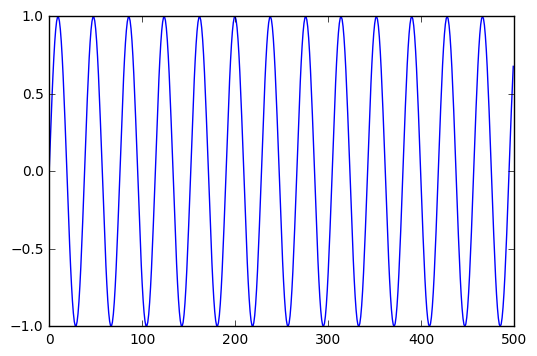

In [14]:
# Two signals have the same frequencies but with a shift in time
N = 500
t = np.arange(N)
a = np.random.rand(4)*.61

x = np.sin(a[0]*(t)) #+ np.cos(a[1]*(t)) #+ np.cos(a[2]*(t))#+np.cos(a[3]*(t))+ .1*np.random.rand(N)
plt.plot(x)

In [15]:
N = 1000
t = np.arange(N)
Waves = []
for i in range(2000):
    
    a = np.random.rand(4)*.6
    x = np.sin(a[0]*(t)) #+ np.cos(a[1]*(t)) #+ np.cos(a[2]*(t))#+np.cos(a[3]*(t))+ .1*np.random.rand(N)
    Waves.append(x[:,np.newaxis])
Waves = np.asarray(Waves)
Waves.shape

(2000, 1000, 1)

In [16]:
import random
time_lag = 20
train_test_row=1000
train_data = []
test_data= []

for r in range(train_test_row):
    for t in range(0,Waves.shape[1]-time_lag-1):
        train_data.append(Waves[r,range(t,t+time_lag+1),:])
        
train_data = np.asarray(train_data)    
    
random.shuffle(train_data)
# train_data = np.transpose(train_data,[1,0,2]) #time,batch,inputdim

for r in range(train_test_row,train_test_row+1000):
    for t in range(0,Waves.shape[1]-time_lag-1):
        test_data.append(Waves[r,range(t,t+time_lag+1),:])
        
test_data = np.asarray(test_data)    

# random.shuffle(test_data)
# test_data = np.transpose(test_data,[1,0,2]) #time,batch,inputdim

In [17]:
print train_data.shape
print test_data.shape

(979000, 21, 1)
(979000, 21, 1)


In [18]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import random
from random import shuffle
import tensorflow as tf

NUM_EXAMPLES = 20000
INPUT_SIZE    = 1       # 1 bits per timestep
RNN_HIDDEN    = 20
OUTPUT_SIZE   = 1       # 1 bit per timestep
TINY          = 1e-6    # to avoid NaNs in logs
LEARNING_RATE = 0.01

tf.reset_default_graph()

test_input = test_data[:NUM_EXAMPLES,:time_lag,:]
test_output = test_data[:NUM_EXAMPLES,time_lag,:]
train_input = train_data[:NUM_EXAMPLES,:time_lag,:]
train_output = train_data[:NUM_EXAMPLES,time_lag,:]

print "test and training data loaded"



data = tf.placeholder(tf.float32, [None, time_lag,INPUT_SIZE]) #Number of examples, number of input, dimension of each input
target = tf.placeholder(tf.float32, [None, OUTPUT_SIZE])

num_hidden = 24
num_layers=1
cell = tf.nn.rnn_cell.LSTMCell(num_hidden,state_is_tuple=True)
cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers, state_is_tuple=True)
val, _ = tf.nn.dynamic_rnn(cell, data, dtype=tf.float32,)
val = tf.transpose(val, [1, 0, 2])
last = tf.gather(val, int(val.get_shape()[0]) - 1)

weight = tf.Variable(tf.truncated_normal([num_hidden, int(target.get_shape()[1])]))
bias = tf.Variable(tf.constant(0.1, shape=[target.get_shape()[1]]))

# prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)

prediction = tf.matmul(last, weight) + bias

error = tf.reduce_sum(tf.pow(target-prediction, 2))
# error = tf.reduce_mean(error)

# cross_entropy = -tf.reduce_sum(target * tf.log(tf.clip_by_value(prediction,1e-10,1.0)))
optimizer = tf.train.AdamOptimizer()
minimize = optimizer.minimize(error)

# mistakes = tf.not_equal(tf.argmax(target, 1), tf.argmax(prediction, 1))
# error = tf.reduce_mean(tf.cast(mistakes, tf.float32))

accuracy = tf.abs(1-(target -prediction)/target)*100


test and training data loaded


In [19]:
print test_input.shape,test_output.shape, train_input.shape,train_output.shape

(20000, 20, 1) (20000, 1) (20000, 20, 1) (20000, 1)


In [20]:
init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

batch_size = 100
no_of_batches = int(len(train_input)) / batch_size
epoch = 50
for i in range(epoch):
    ptr = 0
    for j in range(no_of_batches):
        inp, out = train_input[ptr:ptr+batch_size], train_output[ptr:ptr+batch_size]
        ptr+=batch_size
        sess.run(minimize,{data: inp, target: out})
    if i%2 ==0:
        incorrect = sess.run(error,{data: inp, target: out})
        print "Epoch {} error: {}".format(i,incorrect*100)

Epoch 0 error: 151.137661934
Epoch 2 error: 8.03158283234
Epoch 4 error: 5.75895793736
Epoch 6 error: 3.59865501523
Epoch 8 error: 3.99956032634
Epoch 10 error: 1.65121518075
Epoch 12 error: 0.780969532207
Epoch 14 error: 0.483778258786
Epoch 16 error: 0.301916198805
Epoch 18 error: 0.314855552278
Epoch 20 error: 0.149866065476
Epoch 22 error: 0.188259780407
Epoch 24 error: 0.22558174096
Epoch 26 error: 0.343631673604
Epoch 28 error: 0.317805842496
Epoch 30 error: 0.23353160359
Epoch 32 error: 0.146339193452
Epoch 34 error: 0.135138735641
Epoch 36 error: 0.0324470922351
Epoch 38 error: 0.0912318646442
Epoch 40 error: 0.0711301923729
Epoch 42 error: 0.179471354932
Epoch 44 error: 0.362430373207
Epoch 46 error: 0.256106816232
Epoch 48 error: 0.164400832728


In [21]:
test_preds = sess.run(prediction,{data: test_input, target: test_output})

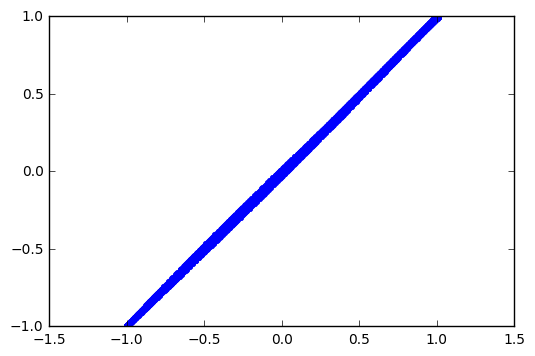

In [22]:
# for i in range(1):
plt.subplot(111)
plt.plot(test_preds[:,0],test_output[:,0],'.')

## One Step Ahead Prediction 

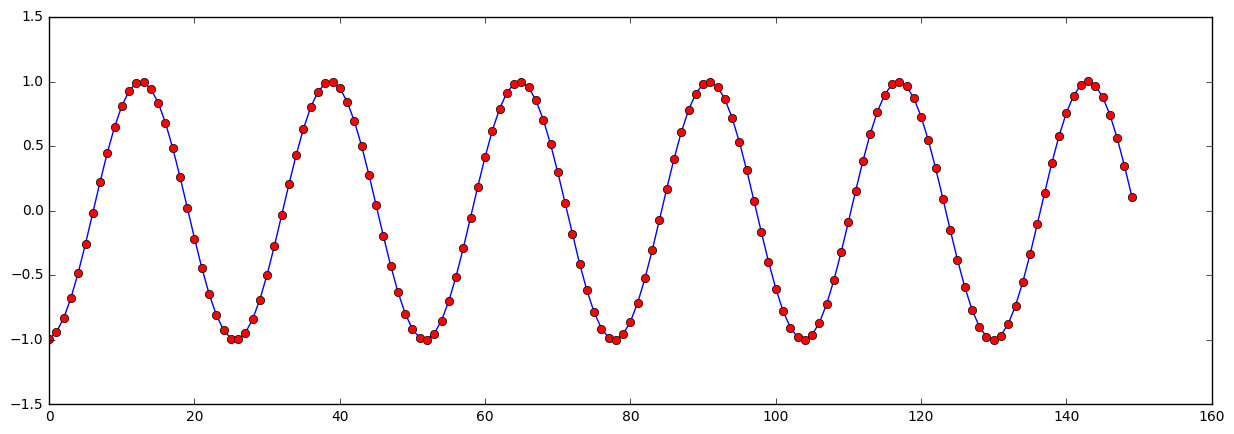

In [23]:
fig = plt.figure(figsize=(15,5))
plt.plot(test_output[:150,0],'.-')
plt.plot(test_preds[:150,0],'or')

## Several Step ahead prediction
## Run sequenctially and replace the vectors with predictions 

In [28]:

N = 1000
t = np.arange(N)
a = np.random.rand(4)*.6
test_wave = np.sin(a[0]*(t)) #+ np.cos(a[1]*(t)) #+ np.cos(a[2]*(t))#+np.cos(a[3]*(t))+ .1*np.random.rand(N)
test_wave_rnn = []
for t in range(0,test_wave.shape[0]-time_lag-1):
    test_wave_rnn.append(test_wave[range(t,t+time_lag+1)])
        
test_wave_rnn = np.asarray(test_wave_rnn)    
test_wave_rnn.shape

(979, 21)

In [29]:
r = 0
inp = test_input[r:r+1]
inp = test_wave_rnn[:1,:time_lag][:,:,np.newaxis]
preds = []
for step in range(1,500):
    
    pred = sess.run(prediction,{data:inp})
    preds.append(pred[0])
    pred_len = len(preds)
    if pred_len<time_lag:
        x = test_wave_rnn[step:step+1,:time_lag]
        x[0,-pred_len:] = preds[-pred_len:]
        inp = np.asarray(x)[:,:,np.newaxis]
    else:
        x = np.asarray(preds[-time_lag:])
        inp = np.asarray(x)[np.newaxis,:,:]
preds = np.asarray(preds)

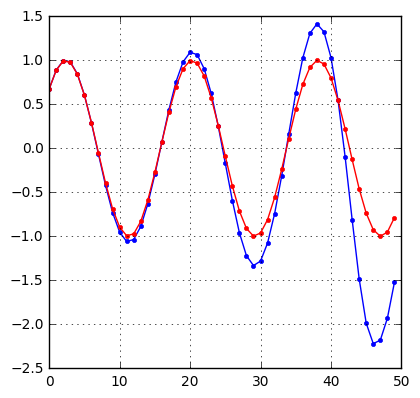

In [30]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)

plt.plot(preds[:50,0],'.-')
plt.plot(test_wave_rnn[:50,time_lag],'.-r')

# plt.plot(Waves[r:r+1,range(t+time_lag,t+time_lag+3),0].T,'.-r')
plt.grid()

# Chaotic Systems
## Deterministic but Unpredictable!
#### e.g. Lorenz curve

In [6]:
from IPython.display import HTML
HTML("""
<video width="600" height="400" controls>
  <source src="files/Images/lorentz_attractor.mp4" type="video/mp4">
</video>
""")

## Now Let's generate some trajectories

In [3]:
#Code from: https://jakevdp.github.io/blog/2013/02/16/animating-the-lorentz-system-in-3d/

import numpy as np
from scipy import integrate

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
%matplotlib inline
N_trajectories = 2000


#dx/dt = sigma(y-x)
#dy/dt = x(rho-z)-y
#dz/dt = xy-beta*z

def lorentz_deriv((x, y, z), t0, sigma=10., beta=8./3, rho=28.0):
    """Compute the time-derivative of a Lorentz system."""
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]


# Choose random starting points, uniformly distributed from -15 to 15
np.random.seed(1)
x0 = -15 + 30 * np.random.random((N_trajectories, 3))

# Solve for the trajectories
t = np.linspace(0, 20, 2000)
x_t = np.asarray([integrate.odeint(lorentz_deriv, x0i, t)
                  for x0i in x0])


In [4]:
x_t.shape

(2000, 2000, 3)

In [5]:
Data = x_t[:,range(0,2000,6)]
Data.shape

(2000, 334, 3)

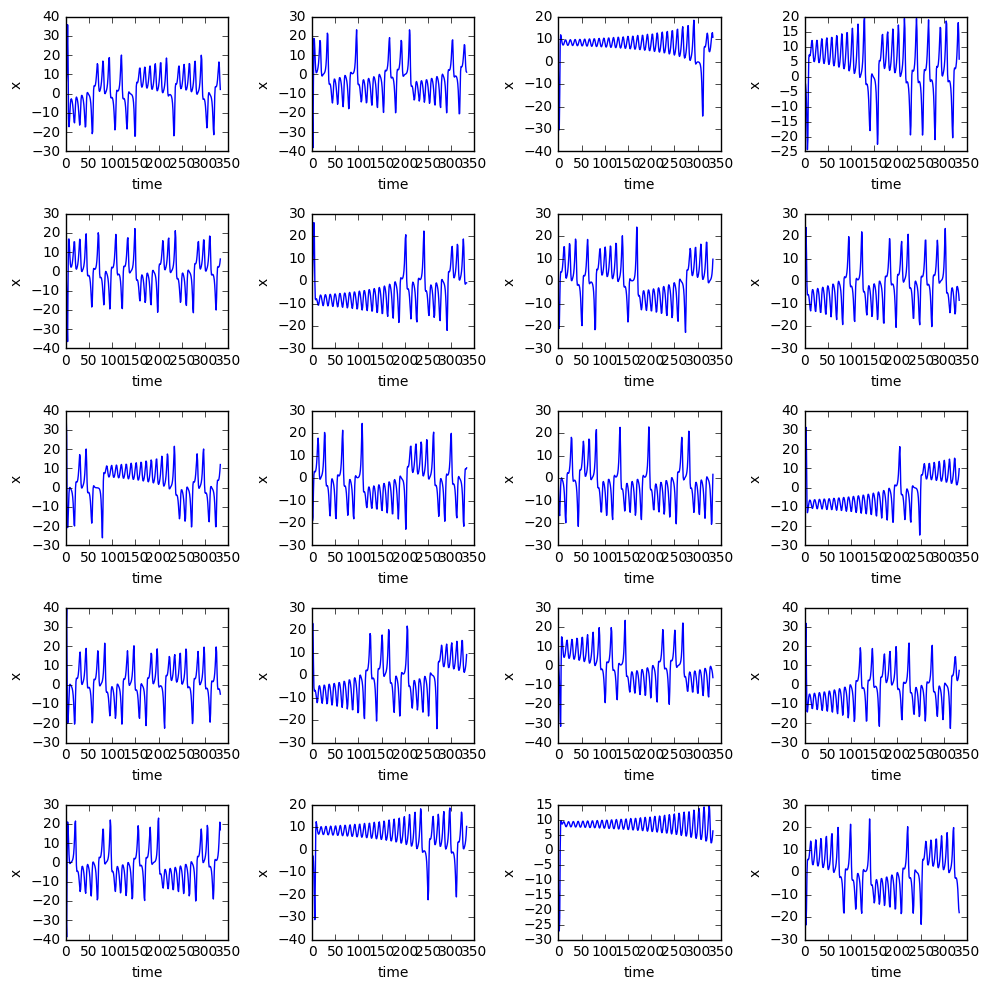

In [6]:
# No regularity in the behavior 
# The effect of initial value
figure =plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,4,i+1);
    plt.plot(Data[i,:,1]);
    plt.xlabel('time')
    plt.ylabel('x')
plt.tight_layout();

In [7]:
import random
time_lag = 1
train_test_row=1000
train_data = []
test_data= []

for r in range(train_test_row):
    for t in range(0,Data.shape[1]-time_lag-1):
        train_data.append(Data[r,range(t,t+time_lag+1),:])
        
train_data = np.asarray(train_data)    
    
random.shuffle(train_data)
# train_data = np.transpose(train_data,[1,0,2]) #time,batch,inputdim

for r in range(train_test_row,train_test_row+1000):
    for t in range(0,Data.shape[1]-time_lag-1):
        test_data.append(Data[r,range(t,t+time_lag+1),:])
        

# We don't need to shuffle it and later easily will use it for predictions        
test_data = np.asarray(test_data)    


In [8]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import random
from random import shuffle
import tensorflow as tf
tf.reset_default_graph()

NUM_EXAMPLES = 20000
INPUT_SIZE    = 3       # 2 bits per timestep
RNN_HIDDEN    = 20
OUTPUT_SIZE   = 3       # 1 bit per timestep
TINY          = 1e-6    # to avoid NaNs in logs
LEARNING_RATE = 0.01



test_input = test_data[:NUM_EXAMPLES,:time_lag,:]
test_output = test_data[:NUM_EXAMPLES,time_lag,:]
train_input = train_data[:NUM_EXAMPLES,:time_lag,:]
train_output = train_data[:NUM_EXAMPLES,time_lag,:]

print "test and training data loaded"



data = tf.placeholder(tf.float32, [None, time_lag,INPUT_SIZE]) #Number of examples, number of input, dimension of each input
target = tf.placeholder(tf.float32, [None, OUTPUT_SIZE])

num_hidden = 24
num_layers=2
cell = tf.nn.rnn_cell.LSTMCell(num_hidden,state_is_tuple=True)
cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers, state_is_tuple=True)
val, _ = tf.nn.dynamic_rnn(cell, data, dtype=tf.float32)
val = tf.transpose(val, [1, 0, 2])
last = tf.gather(val, int(val.get_shape()[0]) - 1)

weight = tf.Variable(tf.truncated_normal([num_hidden, int(target.get_shape()[1])]))
bias = tf.Variable(tf.constant(0.1, shape=[target.get_shape()[1]]))

# prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)

prediction = tf.matmul(last, weight) + bias

error = tf.reduce_sum(tf.pow(target-prediction, 2))
# error = tf.reduce_mean(error)

# cross_entropy = -tf.reduce_sum(target * tf.log(tf.clip_by_value(prediction,1e-10,1.0)))
optimizer = tf.train.AdamOptimizer()
minimize = optimizer.minimize(error)

# mistakes = tf.not_equal(tf.argmax(target, 1), tf.argmax(prediction, 1))
# error = tf.reduce_mean(tf.cast(mistakes, tf.float32))

accuracy = tf.abs(1-(target -prediction)/target)*100



test and training data loaded


In [9]:
print test_input.shape,test_output.shape, train_input.shape,train_output.shape

(20000, 1, 3) (20000, 3) (20000, 1, 3) (20000, 3)


In [10]:
init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

batch_size = 200
no_of_batches = int(len(train_input)) / batch_size
epoch = 100
for i in range(epoch):
    ptr = 0
    for j in range(no_of_batches):
        inp, out = train_input[ptr:ptr+batch_size], train_output[ptr:ptr+batch_size]
        ptr+=batch_size
        sess.run(minimize,{data: inp, target: out})
    if i%3 ==0:
        incorrect = sess.run(error,{data: inp, target: out})
        print "Epoch {} error: {}".format(i,incorrect*100)
        

Epoch 0 error: 11489012.5
Epoch 3 error: 2854307.03125
Epoch 6 error: 1628328.22266
Epoch 9 error: 959440.625
Epoch 12 error: 607786.425781
Epoch 15 error: 404043.62793
Epoch 18 error: 279811.938477
Epoch 21 error: 201083.483887
Epoch 24 error: 148937.82959
Epoch 27 error: 111654.541016
Epoch 30 error: 83870.2148438
Epoch 33 error: 63246.661377
Epoch 36 error: 48217.4102783
Epoch 39 error: 37168.8842773
Epoch 42 error: 29102.8045654
Epoch 45 error: 23247.1557617
Epoch 48 error: 18867.8787231
Epoch 51 error: 15487.5152588
Epoch 54 error: 12921.7697144
Epoch 57 error: 11046.9238281
Epoch 60 error: 9603.9276123
Epoch 63 error: 8395.11413574
Epoch 66 error: 7303.97186279
Epoch 69 error: 6400.340271
Epoch 72 error: 5572.66235352
Epoch 75 error: 4741.63131714
Epoch 78 error: 3892.06161499
Epoch 81 error: 3123.98872375
Epoch 84 error: 2584.26246643
Epoch 87 error: 2203.18202972
Epoch 90 error: 1926.78127289
Epoch 93 error: 1687.9196167
Epoch 96 error: 1515.82260132
Epoch 99 error: 1395.791435

In [11]:
test_preds = sess.run(prediction,{data: test_input, target: test_output})

In [12]:
ac = sess.run(accuracy,{data:test_input, target: test_output})

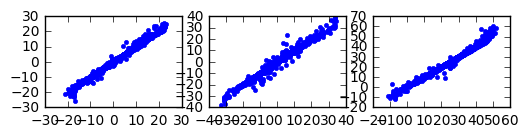

In [13]:
for i in range(3):
    plt.subplot(3,3,i+1)
    plt.plot(test_preds[:,i],test_output[:,i],'.')

## One Step Ahead Prediction 

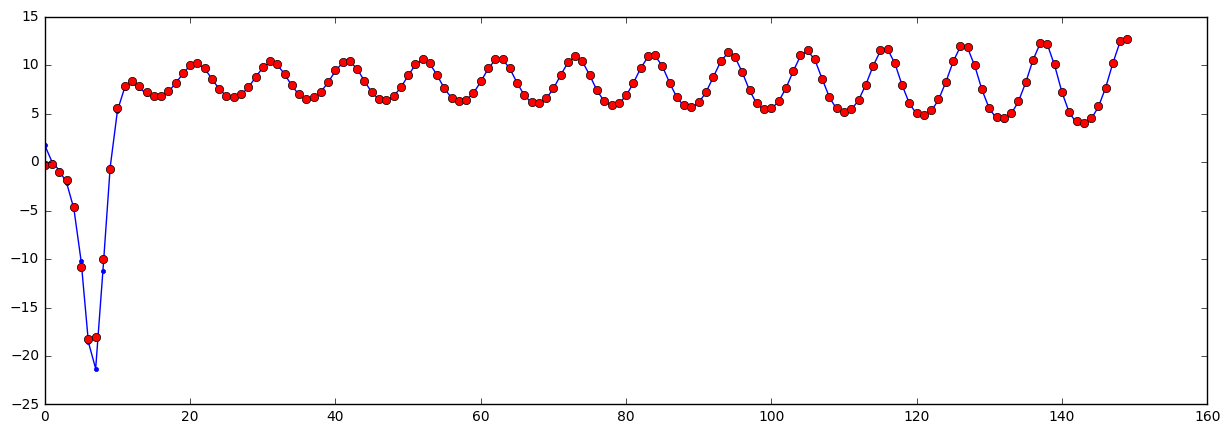

In [14]:
fig = plt.figure(figsize=(15,5))
plt.plot(test_output[:150,0],'.-')
plt.plot(test_preds[:150,0],'or')

# Run sequenctially 

In [72]:
r = train_test_row+900
t = 80
inp = Data[r:r+1,range(t,t+time_lag),:]
preds = []
for step in range(1800):
    
    pred = sess.run(prediction,{data: inp})
    preds.append(pred[0])
    pred_len = len(preds)
    pred_len = np.minimum(pred_len,time_lag)
    x = list(inp[0,:,:])
    x = x[step+1:]+preds[-pred_len:]
    inp = np.asarray(x)[np.newaxis,:,:]
    
    
preds = np.asarray(preds)

In [71]:
# preds1 = preds.copy()
# preds2 = preds.copy()
# preds3 = preds.copy()

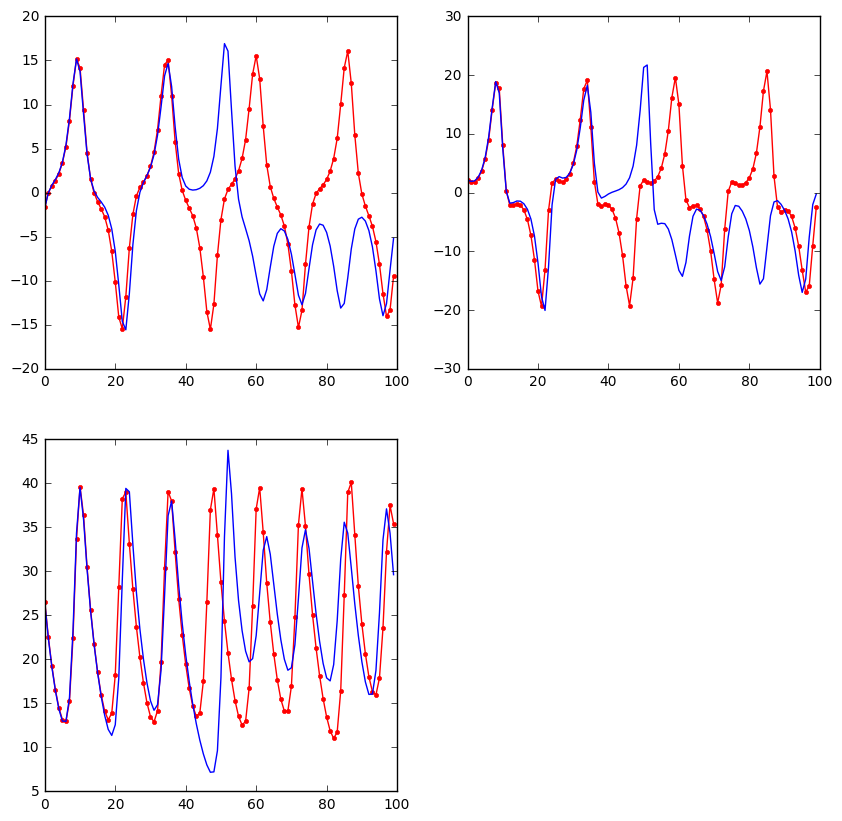

In [73]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(preds[:100,0],'.-r')
plt.plot(Data[r:r+1,range(t+time_lag,t+time_lag+100),0].T)

plt.subplot(2,2,2)
plt.plot(preds[:100,1],'.-r')
plt.plot(Data[r:r+1,range(t+time_lag,t+time_lag+100),1].T)

plt.subplot(2,2,3)
plt.plot(preds[:100,2],'.-r')
plt.plot(Data[r:r+1,range(t+time_lag,t+time_lag+100),2].T)


In [77]:
pred_trajs = preds[np.newaxis,:,:]
# pred_trajs = np.concatenate((preds3[np.newaxis,:Data.shape[1]-(t+time_lag),:],preds2[np.newaxis,:Data.shape[1]-(t+time_lag),:],preds1[np.newaxis,:Data.shape[1]-(t+time_lag),:],preds[np.newaxis,:Data.shape[1]-(t+time_lag),:]),axis=0)

# pred_trajs = np.concatenate((Data[r:r+1,t+time_lag:,:],preds[np.newaxis,:Data.shape[1]-(t+time_lag),:]),axis=0)
pred_trajs.shape

(1, 1800, 3)

In [78]:
# Set up figure & 3D axis for animation
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
ax.axis('off')
plt.set_cmap(plt.cm.YlOrRd_r)
# plt.set_cmap(plt.cm.hot)
# choose a different color for each trajectory
N_trajectories = pred_trajs.shape[0]
colors = plt.cm.jet_r(np.linspace(0, 1, N_trajectories))


# set up lines and points
lines = sum([ax.plot([], [], [], '-', c=c)
             for c in colors], [])
pts = sum([ax.plot([], [], [], 'o', c=c)
           for c in colors], [])

# prepare the axes limits
ax.set_xlim((-25, 25))
ax.set_ylim((-35, 35))
ax.set_zlim((5, 55))

# set point-of-view: specified by (altitude degrees, azimuth degrees)
ax.view_init(30, 0)

# initialization function: plot the background of each frame
def init():
    for line, pt in zip(lines, pts):
        line.set_data([], [])
        line.set_3d_properties([])

        pt.set_data([], [])
        pt.set_3d_properties([])
    return lines + pts

# animation function.  This will be called sequentially with the frame number
def animate(i):
    # we'll step two time-steps per frame.  This leads to nice results.
    i = (2 * i) % x_t.shape[1]
    
    
    for line, pt, xi in zip(lines, pts, x_t):
        x, y, z = xi[:i].T
        line.set_data(x, y)
        line.set_3d_properties(z)

        pt.set_data(x[-1:], y[-1:])
        pt.set_3d_properties(z[-1:])

    ax.view_init(30, 0.3 * i)
    fig.canvas.draw()
    return lines + pts

# instantiate the animator.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=500, interval=10, blit=True)

# Save as mp4. This requires mplayer or ffmpeg to be installed
anim.save('./Images/lorenz_preds.mp4', fps=15, extra_args=['-vcodec', 'libx264'],dpi=200)

plt.close()

## It can't predict the whole process, but ...
# Seemingly it has learned the underlying dynamics and inter-dependencies
### (i.e. the differential equations)

In [5]:
from IPython.display import HTML
HTML("""
<video width="600" height="400" controls>
  <source src="files/Images/lorenz_preds.mp4" type="video/mp4">
</video>
""")

# One possible application of the trained  RNN:
##  For resampling on dependent observations! (like a stochastic process)
![](Images/srn_elman.png)

<hr style="height:3px;border:none;color:stillblue;background-color:black;" />
# Financial Time Series
## Forex 
#### Can we learn it as well? We don't know if there is an underlying system there.

In [368]:
import glob
import os
path = './Data/Forex_10m/'
path =  './Data/Forex_hourly/'
all_pairs = []
counter = 1
for filename in glob.glob(os.path.join(path, '*.csv')):
    all_pairs.append(filename)

print len(all_pairs)

14


In [369]:
all_opens = pd.DataFrame()
for pair in all_pairs[:]:
    DF = pd.read_csv(pair,index_col=0)
    Ticker = pair.replace(path,'').replace('.csv','')
    DF[Ticker] = DF[Ticker].fillna(method='backfill',limit=1,axis=0)
    all_opens[Ticker] = DF[Ticker]
    print DF.index[0],DF.index[-1], Ticker, DF.shape

2001-01-02 23:00:00 2017-03-31 20:00:00 AUDJPY (142366, 1)
2001-01-02 23:00:00 2017-03-31 20:00:00 AUDUSD (142366, 1)
2001-01-02 23:00:00 2017-03-31 20:00:00 CHFJPY (142366, 1)
2001-01-02 23:00:00 2017-03-31 20:00:00 EURCAD (142366, 1)
2001-01-02 23:00:00 2017-03-31 20:00:00 EURCHF (142366, 1)
2001-01-02 23:00:00 2017-03-31 20:00:00 EURGBP (142366, 1)
2001-01-02 23:00:00 2017-03-31 20:00:00 EURJPY (142366, 1)
2001-01-02 23:00:00 2017-03-31 20:00:00 EURUSD (142366, 1)
2001-01-02 23:00:00 2017-03-31 20:00:00 GBPCHF (142366, 1)
2001-01-02 23:00:00 2017-03-31 20:00:00 GBPJPY (142366, 1)
2001-01-02 23:00:00 2017-03-31 20:00:00 GBPUSD (142366, 1)
2001-01-02 23:00:00 2017-03-31 20:00:00 USDCAD (142366, 1)
2001-01-02 23:00:00 2017-03-31 20:00:00 USDCHF (142366, 1)
2001-01-02 23:00:00 2017-03-31 20:00:00 USDJPY (142366, 1)


In [370]:
all_opens.head()

,AUDJPY,AUDUSD,CHFJPY,EURCAD,EURCHF,EURGBP,EURJPY,EURUSD,GBPCHF,GBPJPY,GBPUSD,USDCAD,USDCHF,USDJPY
Date,,,,,,,,,,,,,,
2001-01-02 23:00:00,64.285435,0.561779,71.512308,1.419355,1.520868,0.632968,108.794898,0.950700,2.401669,171.806923,1.501474,1.492754,1.599382,114.405116
2001-01-03 00:00:00,64.429483,0.562908,71.499831,1.418677,1.521016,0.632986,108.781897,0.950402,2.401876,171.778475,1.501043,1.492696,1.600027,114.428036
2001-01-03 01:00:00,64.508947,0.563557,71.505614,1.419098,1.520830,0.632505,108.779167,0.950341,2.403367,171.897818,1.502067,1.493226,1.599927,114.434074
2001-01-03 02:00:00,64.510862,0.563386,71.510351,1.418898,1.521014,0.632103,108.800667,0.950155,2.405223,172.048276,1.502704,1.493200,1.600433,114.477679
2001-01-03 03:00:00,64.664310,0.564420,71.561000,1.418656,1.520996,0.632241,108.873273,0.950166,2.404674,172.126333,1.502437,1.492967,1.600336,114.553750


(50, 14)


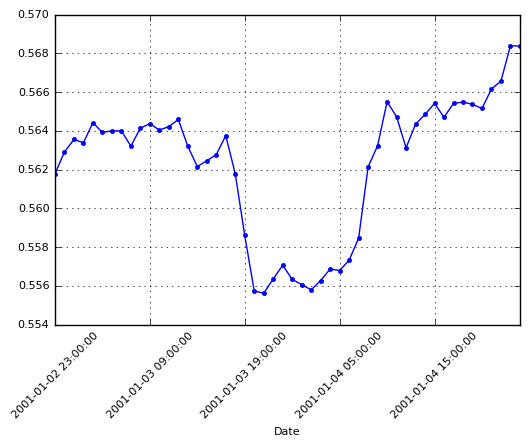

In [390]:
DF  = all_opens.ix[:50]
print DF.shape
DF = DF.fillna(method='backfill',limit=1,axis=0)
DF[DF.columns[1:2]].plot(logy=False,legend=False,rot=45,style='.-',grid=True)

In [372]:
import random
time_lag = 20
train_data = []
maxdlen = min(all_opens.shape[0],250000)
for t in range(0,maxdlen-time_lag-1):
        train_data.append(all_opens.values[:][range(t,t+time_lag+1),:])
train_data = np.asarray(train_data)

In [373]:
indnan = np.isnan(train_data).sum(axis=2).sum(axis=1)
ind = indnan==0
train_data = train_data[ind]
train_data.shape
print train_data.shape
NUM_EXAMPLES = 60000
test_data = train_data[NUM_EXAMPLES:]
train_data = train_data[:NUM_EXAMPLES]
print train_data.shape
print test_data.shape
random.shuffle(train_data)

(83041, 21, 14)
(60000, 21, 14)
(23041, 21, 14)


In [374]:
pd.DataFrame(data=all_opens.columns).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,AUDJPY,AUDUSD,CHFJPY,EURCAD,EURCHF,EURGBP,EURJPY,EURUSD,GBPCHF,GBPJPY,GBPUSD,USDCAD,USDCHF,USDJPY


# predicting the real values of one ticker 

In [379]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import random
from random import shuffle
import tensorflow as tf
tf.reset_default_graph()



# Target = sel_cols
Target = [12]
sel_cols = [7,10,11,13,12]


NUM_EXAMPLES = 20000
INPUT_SIZE    = len(sel_cols)           
RNN_HIDDEN    = 20
OUTPUT_SIZE   = len(Target)      
TINY          = 1e-6    # to avoid NaNs in logs
LEARNING_RATE = 0.01



test_input = train_data[:NUM_EXAMPLES,:time_lag,sel_cols]
if len(Target)>1:
    test_output = train_data[:NUM_EXAMPLES,time_lag,Target]
    train_output = train_data[:NUM_EXAMPLES,time_lag,Target]
else:
    test_output = train_data[:NUM_EXAMPLES,time_lag,Target[0]:Target[0]+1]
    train_output = train_data[:NUM_EXAMPLES,time_lag,Target[0]:Target[0]+1]
train_input = train_data[:NUM_EXAMPLES,:time_lag,sel_cols]
print "test and training data loaded"



data = tf.placeholder(tf.float32, [None, time_lag,INPUT_SIZE]) #Number of examples, number of input, dimension of each input
target = tf.placeholder(tf.float32, [None, OUTPUT_SIZE])

num_hidden = 24
num_layers=2
cell = tf.nn.rnn_cell.LSTMCell(num_hidden,state_is_tuple=True)
cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers, state_is_tuple=True)
val, _ = tf.nn.dynamic_rnn(cell, data, dtype=tf.float32)
val = tf.transpose(val, [1, 0, 2])
last = tf.gather(val, int(val.get_shape()[0]) - 1)

weight = tf.Variable(tf.truncated_normal([num_hidden, int(target.get_shape()[1])]))
bias = tf.Variable(tf.constant(0.1, shape=[target.get_shape()[1]]))

# prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)

prediction = tf.matmul(last, weight) + bias

error = tf.reduce_sum(tf.pow(target-prediction, 2))
# error = tf.reduce_mean(error)

# cross_entropy = -tf.reduce_sum(target * tf.log(tf.clip_by_value(prediction,1e-10,1.0)))
optimizer = tf.train.AdamOptimizer()
minimize = optimizer.minimize(error)

# mistakes = tf.not_equal(tf.argmax(target, 1), tf.argmax(prediction, 1))
# error = tf.reduce_mean(tf.cast(mistakes, tf.float32))

accuracy = tf.abs(1-(target -prediction)/target)*100



test and training data loaded


In [380]:
print test_input.shape,test_output.shape, train_input.shape,train_output.shape

(20000, 20, 5) (20000, 1) (20000, 20, 5) (20000, 1)


In [381]:
init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

batch_size = 200
no_of_batches = int(len(train_input)) / batch_size
epoch = 50
for i in range(epoch):
    ptr = 0
    for j in range(no_of_batches):
        inp, out = train_input[ptr:ptr+batch_size], train_output[ptr:ptr+batch_size]
        ptr+=batch_size
        sess.run(minimize,{data: inp, target: out})
    if i%3 ==0:
        SE = sess.run(error,{data: inp, target: out})
        print "Epoch {} error: {}".format(i,SE)
        

Epoch 0 error: 6.55176973343
Epoch 3 error: 3.89536499977
Epoch 6 error: 1.88389110565
Epoch 9 error: 1.46300196648
Epoch 12 error: 0.986657738686
Epoch 15 error: 0.20409283042
Epoch 18 error: 0.040967117995
Epoch 21 error: 0.0389034375548
Epoch 24 error: 0.0364233143628
Epoch 27 error: 0.0300719439983
Epoch 30 error: 0.0283087622374
Epoch 33 error: 0.0246626548469
Epoch 36 error: 0.0229454580694
Epoch 39 error: 0.0461691729724
Epoch 42 error: 0.0551976561546
Epoch 45 error: 0.0351951792836
Epoch 48 error: 0.0201646499336
Epoch 51 error: 0.032220967114
Epoch 54 error: 0.0309986621141
Epoch 57 error: 0.0301187001169
Epoch 60 error: 0.0380215346813
Epoch 63 error: 0.0487026534975
Epoch 66 error: 0.0469816327095
Epoch 69 error: 0.0302092656493
Epoch 72 error: 0.0180076546967
Epoch 75 error: 0.0161619912833
Epoch 78 error: 0.0271464847028
Epoch 81 error: 0.0429531447589
Epoch 84 error: 0.0427145287395
Epoch 87 error: 0.0419983938336
Epoch 90 error: 0.0414374172688
Epoch 93 error: 0.0416199

In [382]:
test_preds = sess.run(prediction,{data: test_input, target: test_output})


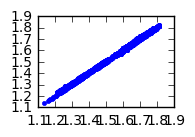

In [383]:
for i in range(len(Target)):
    plt.subplot(3,3,i+1)
    plt.plot(test_preds[:,i],test_output[:,i],'.')

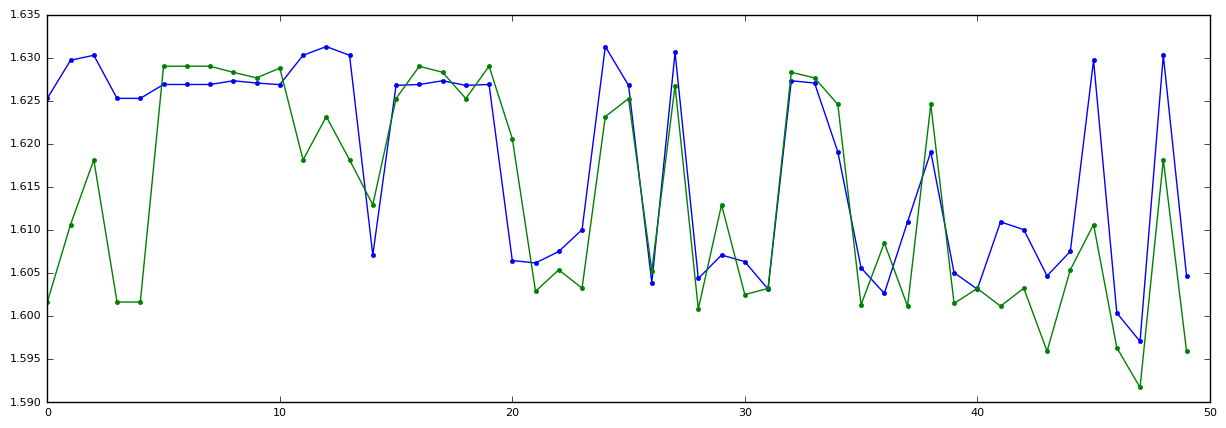

In [393]:
fig = plt.figure(figsize=(15,5))
plt.plot(test_output[:50,0],'.-')
plt.plot(test_preds[:50,0],'.-')


## But what matters is...
# Binary Classification
### If you want to earn some money!

In [409]:
diff_preds = test_input[:,-1,-1]-test_preds[:,-1]
diff_preds[diff_preds>=0]=1
# diff_preds[diff_preds==0]=0
diff_preds[diff_preds<0]=-1

diff_real = test_input[:,-1,-1]-test_output[:,-1]
diff_real[diff_real>=0]=1
# diff_real[diff_real==0]=0
diff_real[diff_real<0]=-1

In [411]:
diff_real

array([-1., -1., -1., ...,  1.,  1.,  1.])

In [396]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="green" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    font = {'size'   : 8}
    plt.rc('font', **font)

Confusion matrix, without normalization
[[   91  9771]
 [  129 10009]]


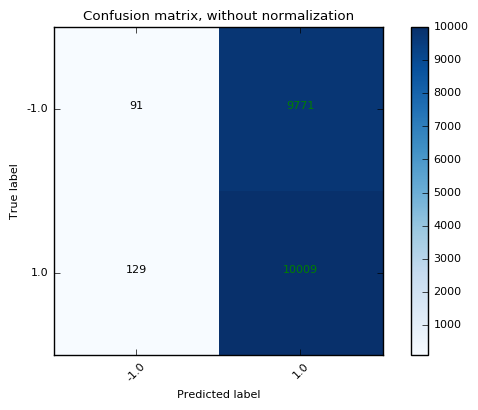

In [398]:
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
cnf_matrix = confusion_matrix(diff_real, diff_preds)

np.set_printoptions(precision=1)
class_names = [str(i) for i in np.unique(diff_real)]
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,normalize=False, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

# Binary Classification

In [503]:
import random
time_lag = 5
train_data = []
maxdlen = min(all_opens.shape[0],250000)
for t in range(0,maxdlen-time_lag-1):
        train_data.append(all_opens.values[:][range(t,t+time_lag+1),:])
train_data = np.asarray(train_data)

In [504]:
indnan = np.isnan(train_data).sum(axis=2).sum(axis=1)
ind = indnan==0
train_data = train_data[ind]
train_data.shape
print train_data.shape
NUM_EXAMPLES = 40000
test_data = train_data[NUM_EXAMPLES:]
train_data = train_data[:NUM_EXAMPLES]
print train_data.shape
print test_data.shape
# random.shuffle(train_data)

(96039, 6, 14)
(40000, 6, 14)
(56039, 6, 14)


In [505]:
pd.DataFrame(data=all_opens.columns).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,AUDJPY,AUDUSD,CHFJPY,EURCAD,EURCHF,EURGBP,EURJPY,EURUSD,GBPCHF,GBPJPY,GBPUSD,USDCAD,USDCHF,USDJPY


In [506]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import random
from random import shuffle
import tensorflow as tf
tf.reset_default_graph()

sel_cols = [7,10,12]


Target = 12
print 'predicting {}'.format(all_opens.columns[Target])

n_ahead = 1
# train_output = train_data[:,time_lag,Target].copy()
train_output = 100*np.diff(train_data[:,time_lag,Target])/train_data[n_ahead::,time_lag-1,Target]
train_output = np.around(train_output,decimals=2)

train_data[n_ahead:,time_lag,Target]= train_output

#no empty
train_data= train_data[n_ahead:]


random.shuffle(train_data)


train_input = train_data[:,:time_lag,sel_cols].copy()
train_output = train_data[:,time_lag,Target].copy()


print train_output.shape, train_input.shape






test_output = test_data[:,time_lag,Target].copy()
test_output = 100*np.diff(test_output)/test_data[n_ahead::,time_lag-1,Target]
test_data[n_ahead:,time_lag,Target]= test_output

#no empty
test_data= test_data[n_ahead:]

# No need to shuffle
test_input = test_data[:,:time_lag,sel_cols]
test_output = np.around(test_output,decimals=2)





# test_input = test_data[n_ahead:,:time_lag,sel_cols]
# test_output =100*np.diff(test_data[:,time_lag,Target],n=n_ahead)/test_data[:-n_ahead,time_lag,Target]
# test_output = np.around(test_output,decimals=2)
print test_output.shape, test_input.shape



print "test and training data loaded"

predicting USDCHF
(39999,) (39999, 5, 3)
(56038,) (56038, 5, 3)
test and training data loaded


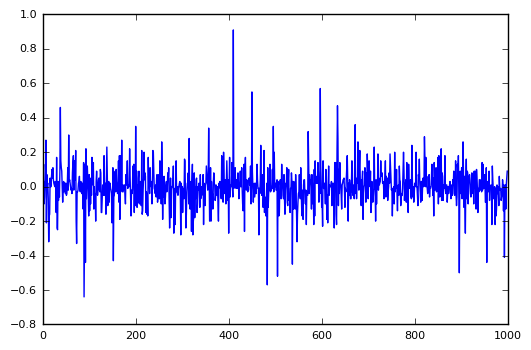

In [507]:
plt.plot(train_output[20000:21000])

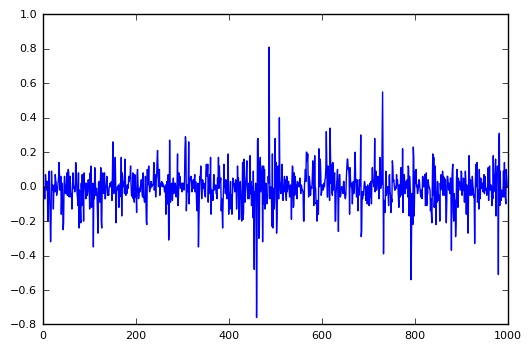

In [508]:
plt.plot(test_output[20000:21000])

In [509]:
DF = pd.DataFrame(data=test_output)
stat = DF.describe(percentiles=[.1,.3,.5,.7,.9]).T
stat

,count,mean,std,min,10%,30%,50%,70%,90%,max
0,56038.0,-0.000202,0.12962,-7.95,-0.11,-0.03,0.0,0.03,0.11,6.32


In [510]:
DF = pd.DataFrame(data=train_output)
stat = DF.describe(percentiles=[.1,.3,.5,.7,.9]).T
stat

,count,mean,std,min,10%,30%,50%,70%,90%,max
0,39999.0,-0.000202,0.116888,-1.05,-0.12,-0.04,0.0,0.04,0.12,1.2


In [511]:
ind_10 = train_output<stat['30%'].values[:]
ind_30 = (train_output>= stat['30%'].values[:])&(train_output< stat['70%'].values[:])
# ind_50 = (train_output>= stat['30%'].values[:])&(train_output< stat['50%'].values[:])
# ind_70 = (train_output>= stat['50%'].values[:])&(train_output< stat['70%'].values[:])
# ind_70p = (train_output>= stat['70%'].values[:])&(train_output< stat['90%'].values[:])
ind_90 = (train_output>= stat['70%'].values[:])

train_output[ind_10] = 0
train_output[ind_30] = 1
# train_output[ind_50] = 2
# train_output[ind_70] = 3
# train_output[ind_70p] = 4
train_output[ind_90] = 2



ind_10 = test_output<stat['30%'].values[:]
ind_30 = (test_output>= stat['30%'].values[:])&(test_output< stat['70%'].values[:])
# ind_50 = (test_output>= stat['30%'].values[:])&(test_output< stat['50%'].values[:])
# ind_70 = (test_output>= stat['50%'].values[:])&(test_output< stat['70%'].values[:])
# ind_70p = (test_output>= stat['70%'].values[:])&(test_output< stat['90%'].values[:])
ind_90 = (test_output>= stat['70%'].values[:])

test_output[ind_10] = 0
test_output[ind_30] = 1
# test_output[ind_50] = 2
# test_output[ind_70] = 3
# test_output[ind_70p] = 4
test_output[ind_90] = 2


In [512]:


# test_output[test_output>= 0]=0 #Long Position
# test_output[test_output<0]=1 #Short Position
# outputs[outputs==0]=0 #Hold
with tf.Session():
    test_Label= tf.one_hot(test_output,len(np.unique(test_output))).eval()

    
    
# train_output[train_output>= 0]=0 #Long Position
# train_output[train_output<0]=1#Short Position
# # outputs[outputs==0]=0 #Hold

with tf.Session():
    train_Label= tf.one_hot(train_output,len(np.unique(train_output))).eval()


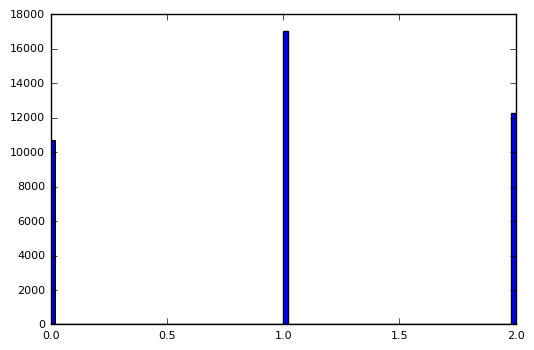

In [513]:
plt.hist(train_output,bins=100);

In [514]:
print train_output[:10]
train_Label[:10]

[ 1.  1.  2.  1.  1.  2.  0.  2.  2.  2.]


array([[ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]], dtype=float32)

In [515]:
# test_input = inputs[NUM_EXAMPLES:]
# test_output = Labels[NUM_EXAMPLES:]
# train_input = inputs[:NUM_EXAMPLES]
# train_output = Labels[:NUM_EXAMPLES]
train_output = train_Label
test_output = test_Label
print train_input.shape, test_input.shape,train_output.shape
print "test and training data loaded"


(39999, 5, 3) (56038, 5, 3) (39999, 3)
test and training data loaded


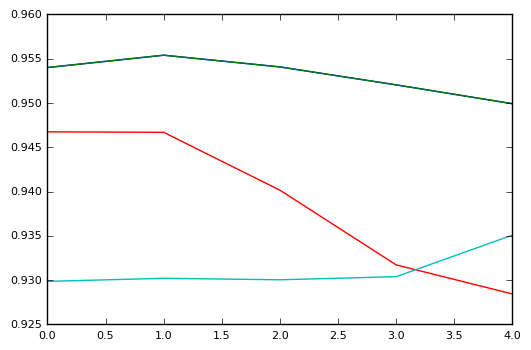

In [516]:
plt.plot(train_input[10,:,0])
plt.plot(train_input[11,:,0])
plt.plot(train_input[42,:,0])
plt.plot(train_input[43,:,0])

In [517]:
train_output.shape

(39999, 3)

In [518]:
INPUT_SIZE    = len(sel_cols)      
RNN_HIDDEN    = 20
OUTPUT_SIZE   =train_output.shape[1]       
TINY          = 1e-6    # to avoid NaNs in logs
LEARNING_RATE = 0.01

tf.reset_default_graph()
data = tf.placeholder(tf.float32, [None, time_lag,INPUT_SIZE]) #Number of examples, number of input, dimension of each input
target = tf.placeholder(tf.float32, [None, OUTPUT_SIZE])

num_hidden = 20
num_layers=2
cell = tf.nn.rnn_cell.LSTMCell(num_hidden,state_is_tuple=True)
cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers, state_is_tuple=True)
cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=.8)
val, _ = tf.nn.dynamic_rnn(cell, data, dtype=tf.float32)
val = tf.transpose(val, [1, 0, 2])
last = tf.gather(val, int(val.get_shape()[0]) - 1)

weight = tf.Variable(tf.truncated_normal([num_hidden, int(target.get_shape()[1])]))
bias = tf.Variable(tf.constant(0.1, shape=[target.get_shape()[1]]))

# prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)

# prediction = tf.sigmoid(tf.matmul(last, weight) + bias)

# # prediction = tf.nn.xw_plus_b(last, weight, bias)
# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(prediction, target))
# optimizer = tf.train.AdamOptimizer()
# minimize = optimizer.minimize(cost)


prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)

cross_entropy = -tf.reduce_sum(target * tf.log(tf.clip_by_value(prediction,1e-10,1.0)))
optimizer = tf.train.AdamOptimizer()
minimize = optimizer.minimize(cross_entropy)

mistakes = tf.not_equal(tf.argmax(target, 1), tf.argmax(prediction, 1))
error = tf.reduce_mean(tf.cast(mistakes, tf.float32))




# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(target,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))




In [519]:
init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

batch_size = 50
no_of_batches = int(len(train_input)) / batch_size
epoch = 30
for i in range(epoch):
    ptr = 0
    for j in range(no_of_batches):
        inp, out = train_input[ptr:ptr+batch_size], train_output[ptr:ptr+batch_size]
        ptr+=batch_size
        sess.run(minimize,{data: inp, target: out})
    if i%3 ==0:
        acc = sess.run(accuracy,{data: inp, target: out})
        print "Epoch {} training accuracy: {}".format(i,acc*100)
        ind = np.random.randint(0,high=test_input.shape[0],size=1000)
        acc = sess.run(accuracy,{data: test_input[:1000], target: test_output[:1000]})
        print "Epoch {} test accuracy: {}".format(i,acc*100)

Epoch 0 training accuracy: 47.9999989271
Epoch 0 test accuracy: 50.1999974251
Epoch 3 training accuracy: 47.9999989271
Epoch 3 test accuracy: 50.1999974251
Epoch 6 training accuracy: 47.9999989271
Epoch 6 test accuracy: 50.1999974251
Epoch 9 training accuracy: 47.9999989271
Epoch 9 test accuracy: 50.1999974251
Epoch 12 training accuracy: 47.9999989271
Epoch 12 test accuracy: 50.1999974251
Epoch 15 training accuracy: 47.9999989271
Epoch 15 test accuracy: 50.1999974251
Epoch 18 training accuracy: 47.9999989271
Epoch 18 test accuracy: 50.1999974251
Epoch 21 training accuracy: 47.9999989271
Epoch 21 test accuracy: 50.1999974251
Epoch 24 training accuracy: 47.9999989271
Epoch 24 test accuracy: 50.1999974251
Epoch 27 training accuracy: 47.9999989271
Epoch 27 test accuracy: 50.1999974251


In [520]:
howmany = 1000
test_preds = sess.run(prediction,{data: test_input[:howmany]})
np.argmax(test_output[:],axis=1).shape
acc = sess.run(accuracy,{data: test_input[:howmany], target: test_output[:howmany]})
print "Epoch {} accuracy: {}".format(i,acc*100)

Epoch 29 accuracy: 50.1999974251


In [521]:
test_input.shape

(56038, 5, 3)

In [522]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    font = {'size'   : 8}
    plt.rc('font', **font)



Normalized confusion matrix
[[ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]]


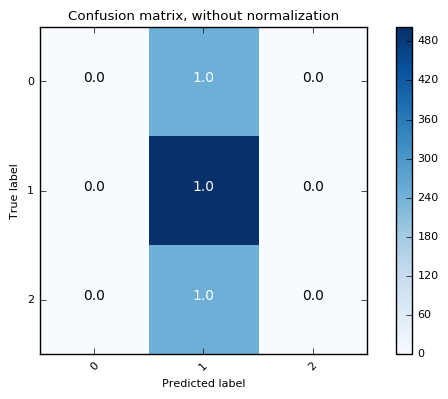

In [523]:
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(test_output[:howmany],axis=1), np.argmax(test_preds,axis=1))
# cnf_matrix = confusion_matrix(np.argmax(test_output[:],axis=1), np.zeros(len(test_preds)))

np.set_printoptions(precision=1)
class_names = [str(i) for i in range(train_output.shape[1])]
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,normalize=True, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

# Conclusion: Doesn't work at the moment!